In [37]:
from skfuzzy import control as ctrl
import numpy as np 
import skfuzzy as fuzz 

## Exercice 1 : Définition de la variable floue Distance_to_next_car

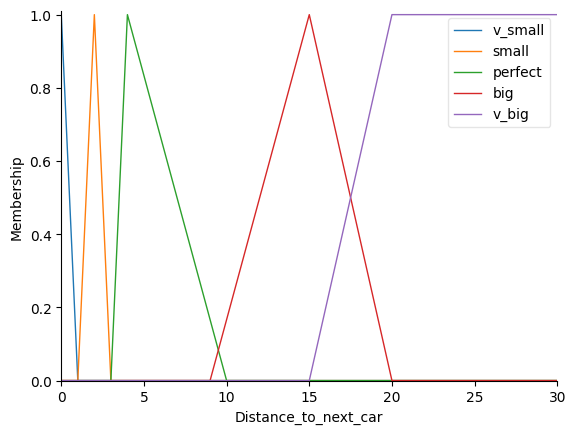

In [ ]:
Distance_to_next_car  = ctrl.Antecedent(np.arange(0,31,1),"Distance_to_next_car")
Distance_to_next_car.automf(names = ["v_small","small","perfect","big","v_big"])
Distance_to_next_car["v_small"] = fuzz.trimf(Distance_to_next_car.universe, [0,0,1])
Distance_to_next_car["small"] = fuzz.trimf(Distance_to_next_car.universe, [1,2,3])
Distance_to_next_car["perfect"] = fuzz.trimf(Distance_to_next_car.universe, [3,4,10])
Distance_to_next_car["big"] = fuzz.trimf(Distance_to_next_car.universe, [9,15,20])
Distance_to_next_car["v_big"] = fuzz.trapmf(Distance_to_next_car.universe, [15,20,30,30])
Distance_to_next_car.view()

## Exercice 2 : Variable floue Speed_change

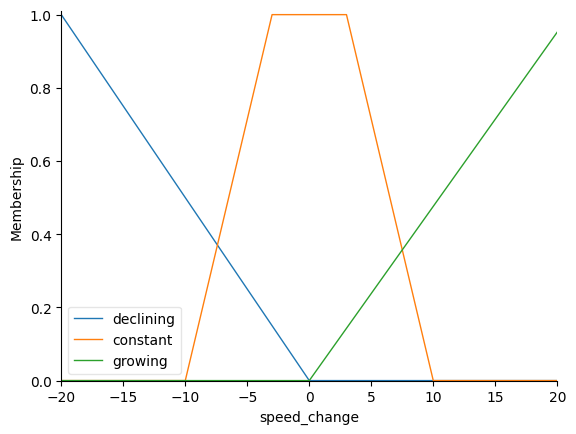

In [39]:
spees_change  = ctrl.Antecedent(np.arange(-20,21,1),"speed_change")
spees_change.automf(names = ["declining","constant","growing"])
spees_change["declining"] = fuzz.trimf(spees_change.universe, [-20,-20,0])
spees_change["constant"] = fuzz.trapmf(spees_change.universe, [-10,-3,3,10])
spees_change["growing"] = fuzz.trimf(spees_change.universe, [0,21,21])
spees_change.view()

## Exercice 3 : Variable de sortie Acceleration_Adjust

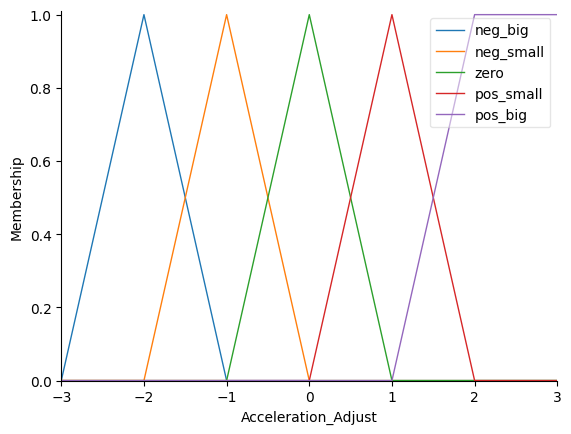

In [40]:
Acceleration_Adjust  = ctrl.Consequent(np.arange(-3,4,1),"Acceleration_Adjust")
Acceleration_Adjust.automf(names = ["neg_big","neg_small","zero","pos_small","pos_big"])
Acceleration_Adjust["neg_big"] = fuzz.trimf(Acceleration_Adjust.universe, [-3,-2,-1.5])
Acceleration_Adjust["neg_small"] = fuzz.trimf(Acceleration_Adjust.universe, [-2,-1,0])
Acceleration_Adjust["zero"] = fuzz.trimf(Acceleration_Adjust.universe, [-0.5,0,0.5])
Acceleration_Adjust["pos_small"] = fuzz.trimf(Acceleration_Adjust.universe, [0,1,2])
Acceleration_Adjust["pos_big"] = fuzz.trapmf(Acceleration_Adjust.universe, [1.5,2,3,3])
Acceleration_Adjust.view()

## Exercice 4 : Base de règles floues et simulation

1.2083333333333333


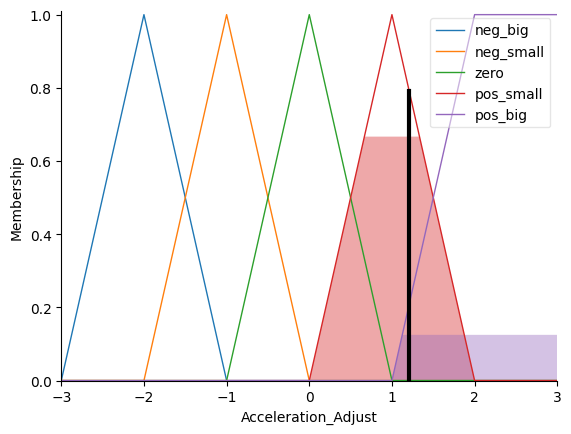

In [41]:
reg1 = ctrl.Rule(Distance_to_next_car['v_small'] & spees_change['declining'], Acceleration_Adjust['neg_small'])
reg2 = ctrl.Rule(Distance_to_next_car['v_small'] & spees_change['constant'], Acceleration_Adjust['neg_big'])
reg3 = ctrl.Rule(Distance_to_next_car['v_small'] & spees_change['growing'], Acceleration_Adjust['neg_big'])

reg4 = ctrl.Rule(Distance_to_next_car['small'] & spees_change['declining'], Acceleration_Adjust['zero'])
reg5 = ctrl.Rule(Distance_to_next_car['small'] & spees_change['constant'], Acceleration_Adjust['neg_small'])
reg6 = ctrl.Rule(Distance_to_next_car['small'] & spees_change['growing'], Acceleration_Adjust['neg_big'])

reg7 = ctrl.Rule(Distance_to_next_car['perfect'] & spees_change['declining'], Acceleration_Adjust['pos_small'])
reg8 = ctrl.Rule(Distance_to_next_car['perfect'] & spees_change['constant'], Acceleration_Adjust['zero'])
reg9 = ctrl.Rule(Distance_to_next_car['perfect'] & spees_change['growing'], Acceleration_Adjust['neg_small'])

reg10 = ctrl.Rule(Distance_to_next_car['big'] & spees_change['declining'], Acceleration_Adjust['pos_big'])
reg11 = ctrl.Rule(Distance_to_next_car['big'] & spees_change['constant'], Acceleration_Adjust['pos_small'])
reg12 = ctrl.Rule(Distance_to_next_car['big'] & spees_change['growing'], Acceleration_Adjust['zero'])

reg13 = ctrl.Rule(Distance_to_next_car['v_big'] & spees_change['declining'], Acceleration_Adjust['pos_big'])
reg14 = ctrl.Rule(Distance_to_next_car['v_big'] & spees_change['constant'], Acceleration_Adjust['pos_big'])
reg15 = ctrl.Rule(Distance_to_next_car['v_big'] & spees_change['growing'], Acceleration_Adjust['pos_small'])

Acceleration_Adjust_ctrl = ctrl.ControlSystem([reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8, reg9, reg10, reg11, reg12, reg13, reg14, reg15])
Acceleration_Adjust_simulation = ctrl.ControlSystemSimulation(Acceleration_Adjust_ctrl)
Acceleration_Adjust.defuzzyfy_method = 'centroid'
Acceleration_Adjust_simulation.input['Distance_to_next_car'] = 13
Acceleration_Adjust_simulation.input['speed_change'] = -2.5
Acceleration_Adjust_simulation.compute()
print(Acceleration_Adjust_simulation.output['Acceleration_Adjust'])
Acceleration_Adjust.view(sim=Acceleration_Adjust_simulation)

# Partie Machine Learning : Prédiction de l'ajustement d'accélération

---

## 1. Génération du dataset synthétique

In [42]:
import pandas as pd

# Initialisation du simulateur flou
Acceleration_Adjust_simulation = ctrl.ControlSystemSimulation(Acceleration_Adjust_ctrl)

# Génération aléatoire des données d’entrée
np.random.seed(42)
n_samples = 1000
data = {
    "Distance_to_next_car": np.random.uniform(0, 30, n_samples),
    "Speed_change": np.random.uniform(-20, 20, n_samples),
}

df = pd.DataFrame(data)

# Calcul de la sortie floue (défuzzifiée)
outputs = []
for i in range(n_samples):
    d = df.loc[i, "Distance_to_next_car"]
    s = df.loc[i, "Speed_change"]
    Acceleration_Adjust_simulation.input["Distance_to_next_car"] = d
    Acceleration_Adjust_simulation.input["speed_change"] = s
    Acceleration_Adjust_simulation.compute()
    outputs.append(Acceleration_Adjust_simulation.output["Acceleration_Adjust"])

df["Acceleration_Adjust"] = outputs

print(df.head())


   Distance_to_next_car  Speed_change  Acceleration_Adjust
0             11.236204    -12.594683             2.089984
1             28.521429      1.676038             2.120522
2             21.959818     14.917833             1.000000
3             17.959755      9.288995             0.704969
4              4.680559     12.262446            -1.000000


##  Entraînement d’un modèle de régression


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Séparation train/test
X = df[["Distance_to_next_car", "Speed_change"]]
y = df["Acceleration_Adjust"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")



MAE : 0.0335
MSE : 0.0058


## Comparaison entre la logique floue et le modèle Machine Learning

### 1. Avantages de la logique floue
- **Explicabilité :**  
  La logique floue permet de comprendre clairement les décisions du système grâce aux règles linguistiques.  
  Chaque règle est interprétable et montre comment les entrées (Distance_to_next_car, Speed_change) influencent la sortie (Acceleration_Adjust).  
- **Robustesse face à l’incertitude :**  
  Le système peut gérer des valeurs imprécises ou floues, ce qui est utile dans des environnements réels où les mesures ne sont pas parfaites.

### 2. Avantages du Machine Learning
- **Précision :**  
  Le modèle de régression (Random Forest) prédit l’ajustement de l’accélération avec une erreur très faible :  
  - MAE : 0.0335  
  - MSE : 0.0058  
  Cela montre que le ML peut approximer très précisément la sortie floue sur de nouvelles données.  
- **Généralisation :**  
  Le modèle ML peut apprendre automatiquement des relations complexes entre les variables et s’adapter à des ensembles de données plus larges ou différents sans avoir à définir explicitement les règles.

### 3. Synthèse
| Méthode        | Avantages principaux              |
|----------------|---------------------------------|
| Logique floue  | Explicabilité, règles compréhensibles, robustesse aux incertitudes |
| Machine Learning | Précision, généralisation, capacité à modéliser des relations complexes |
